# Write and load images

Writing, loading and displaying images are necessary components of the scientific python toolbox for microscopy. In this notebook, we just present some aspects of jupyter notebooks, before playing around with images. 

This notebook is a simple introduction and is not mandatory for the rest of the course, it helps getting into the flow and maybe learning about some new tools.

## 0 - The first cell

Click on the first cell with code and press `shift+enter` to run a single cell. You have more options and shortcuts in the `Edit` and `Cell` menus.

In [4]:
def decode(s):
    '''
    Decode hexadecimal messages.
    '''
    return bytes.fromhex(s)

In [5]:
message = "4C 65 74 27 73 20 73 74 61 72 74 21"

print(decode(message))

b"Let's start!"


## 1 - Creating an image with numpy

In this first real python exercise, we are going to create a `numpy` array representing a 3D stack and learn how to show it in the jupyter notebook. Run the first cell to add the function definition to the current session.

In [50]:
import numpy as np

# This unecessarily complicated, you don't have to understand the function to continue
def get_3D_gaussian(delta_z, size_xy=256, std_xy=20., std_z=3., a0=255):    
    '''
    Return a 2D Gaussian whose standard deviation and amplitude depend on the 
    distance to the central plane z=0.

            Parameters:
                    size_xy (int): Size of the slice in X and Y directions
                    delta_z (int): Distance of the slice to the center (positive 
                                   or negative)
                    a0 (int): Maximum amplitude of the Gaussian. 
                    std_xy (float): Standard deviation in pixels of the Gaussian 
                                    in the X and Y directions.
                    std_z (float): Standard deviation in pixels of the Gaussian 
                                   amplitude in the Z direction.

            Returns:
                    XY slice
    '''
    
    # let's create a grid of values: n+1 values ranging from 0 to n
    n = size_xy
    grid = np.linspace(0, n, n+1)
    
    # create a meshgrid
    x, y = np.meshgrid(grid, grid)
    
    # distance to the center of the grid
    delta_x = x - size_xy / 2
    delta_y = y - size_xy / 2
    d_xy = np.sqrt(delta_x*delta_x+delta_y*delta_y)
    
    # effective standard deviation (small at z=0, larger with distance to the center plane)
    std_xy_eff = std_xy * ( abs(delta_z) + 0.5)
    
    # compute Gaussian in XY
    xy_gauss = np.exp(-( d_xy**2 / (2.0 * std_xy_eff**2 ) ) )
    
    # compute a z-dependent amplitude term
    amplitude = a0 * np.exp(-( delta_z**2 / (2.0 * std_z**2 ) ) )
    
    # return the image with integer values
    return (xy_gauss * amplitude).astype(np.int16)

Let's now call this function to get a single slice:

In [39]:
#######################################################
##### exercise: call the get_3D_gaussian function #####

single_img = get_3D_gaussian(-5)
print(single_img[0:5, 0:5])  # hopefully, it is not just zeroes

[[16 16 16 16 17]
 [16 16 16 17 17]
 [16 16 17 17 17]
 [16 17 17 17 17]
 [17 17 17 17 17]]


Plotting numbers is not the best way to visualize numpy arrays. We can use `matplotlib` to see the array as an **image**. 

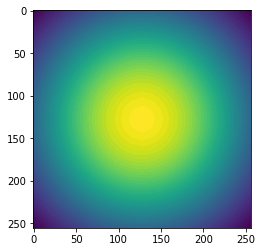

In [43]:
import matplotlib.pyplot as plt

######################################################
##### exercise: plot single_img using matplotlib #####

plt.imshow(single_img)

Often we need to deal with multidimensional images, and since the `get_3D_gaussian` function output is z-dependent, let's create a **stack** with different z-slices.

In [55]:
###############################################
##### exercise: generate a list of images #####
#####                                     #####
##### hint: look at the first few lines   #####
#####       of get_3D_gaussian            #####

dzs = np.linspace(-5, 5, 11)
imgs = [get_3D_gaussian(d) for d in dzs]

Here is a more complicated function to plot images. Since we have a list of images, we would like to be able to compare them side by side.

In [57]:
def plot_images_list(images, titles=None, max_value=255):
    '''
    Plot images i.

            Parameters:
                    images (list): List of 2D numpy arrays
                    titles (list): 
                    max_value (float): Maximum amplitude of the Gaussian.
    '''
    
    # some flexible parameters to adapt the number of rows/cols and size
    root = np.sqrt( len( images ) ).astype(int)
    size = 50 / root  # arbitrary

    # if no title was given
    if titles is None:
        titles = [i for i in range( len(images) )]
    
    # create subplots
    fig, axs = plt.subplots(root, root, figsize=(10, 10))
    
    # now we populate the subplots with images
    for i, ax in enumerate(axs.flatten()):
        
        if i < len(imgs):
            # show image
            ax.imshow(imgs[i], vmin=0, vmax=max_value)
            
            # add title
            ax.set_title(titles[i])
        else:
            # in case the number of suplots is larger than the number of elements in images
            ax.remove()
    plt.show()


Let's use the previous function to plot all the slices.

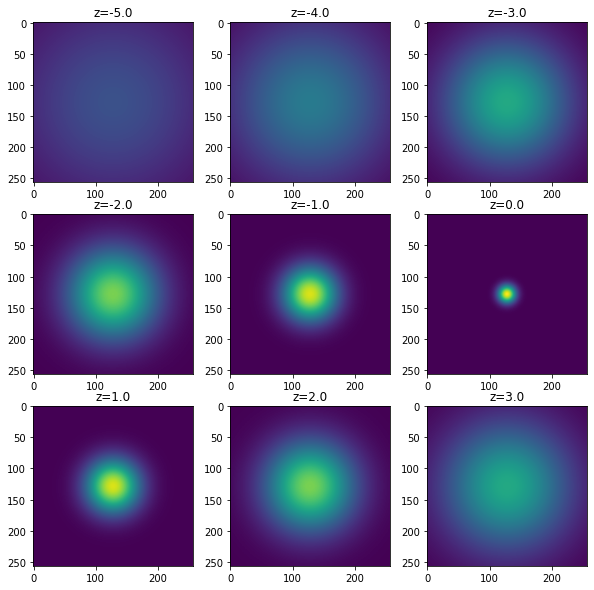

In [58]:
###########################################################
##### exercise:                                       #####
#####   - generate meaningful titles for each subplot #####
#####   - use plot_images_list to plot the images     #####


titles = ['z={}'.format(z) for z in dzs]
plot_images_list(images, titles)

###########################################################
##### Question: the images can be compared because they are
##### plotted with a fixed contrast. Can you see where this
##### happens?

Now, let's create a real stack instead of a list of images.

In [59]:
###############################################################
##### exercise: create a single numpy array from the list #####
#####                                                     #####
##### hint: search how to stack arrays of same dimension  ##### 

stack = np.stack(imgs)
print(f'Shape of the stack: {stack.shape}')

Shape of the stack: (11, 257, 257)


## 2 - Saving a numpy array

The most convenient way to save a `numpy` array is simply to do use the save and load function from `numpy`.

In [65]:
import os
from pathlib import Path

# create a data directory
data = 'Data'
if not Path(data).exists():
    os.mkdir('Data')

# save the image
path = os.path.join(data, 'my_stack.npy')
np.save(path, stack)

# and load it again
loaded_stack = np.load(path)

# check that they are the same (we compare each value in the arrays)
# if no error is thrown, then they are the same!
assert (loaded_stack == stack).all()

## 3 - Saving and loading tiffs

While `.npy` are convenient, they are not typically read by other software or languages. For instance, they would not be convenient to open in ImageJ2/Fiji or add to a presentation. Tiffs are a popular format because they allow multi-dimensional images, extensive metadata and are usually not (lossy) compressed.

There are many librairies to load and save tiffs in Python. We do not have time to review them all, but the differences will be whether they allow 

## 4 - 